In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scienceplots
import pickle
import scipy

from utils import utils
import utils.efinet as efinet
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from imblearn.combine import SMOTETomek

# Plot settings
fpath = "C:/Users/Marek/OneDrive/School/DP/masters-thesis/assets/figures/wesad"
# plt.rcParams["font.family"] = ["Latin Modern Roman"]
plt.rcParams["figure.figsize"] = (5, 5)
plt.style.use("science")
# plt.rcParams["savefig.dpi"] = 300
# plt.rcParams["font.size"] = 20

2023-04-22 21:19:36.425109: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-22 21:19:36.560221: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-22 21:19:37.137065: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Load labels
with open("../data/Merged/WESAD_merged_5s_2s_overlap.pkl", "rb") as f:
    labels = pickle.load(f)
labels = labels["model_label"]

# Load and concat data
with open("../data/GADF_Data/GADF_WESAD_merged_5s_2s_overlap.pkl", "rb") as f:
    gadf_wesad = pickle.load(f)

gcn_wesad = scipy.io.loadmat("../data/GCN_Data/GCN_WESAD_Standard_5s_2s_overlap.mat")
gcn_wesad = np.transpose(gcn_wesad["cause5s"], (0, 2, 3, 1))

L = len(gcn_wesad)

result_wesad = []
for i in range(L):
    result_wesad.append(gcn_wesad[i] + gadf_wesad[i])

data = np.array(result_wesad)

print("Data shape: ", np.shape(data))
print("Counts: \n", pd.value_counts(labels))

Data shape:  (9017, 32, 32, 3)
Counts: 
 0    7027
1    1990
Name: model_label, dtype: int64


In [3]:
# Split data into train and test
X, y = data, labels.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

(7213, 32, 32, 3) (1804, 32, 32, 3) (7213,) (1804,)


In [4]:
model_name = "WESAD_5s50"
lr = 5e-4
epochs = 100
batch_size = 256

# Train model
train_model, eval_model = efinet.build_graph([32, 32, 3], 2, verbose=False)
trained_model = efinet.train(model=train_model, data=((X_train, y_train), (X_test, y_test)),
                             epochs=epochs, lr=lr, model_name=model_name, batch_size=batch_size)







Epoch 1/100
29/29 [==============================] - ETA: 0s - loss: 0.3839 - Efficient_CapsNet_loss: 0.1919 - Generator_loss: 0.4898 - Efficient_CapsNet_accuracy: 0.7595
Epoch 1: val_Efficient_CapsNet_accuracy improved from -inf to 0.77550, saving model to ../results\models
29/29 [==============================] - 4s 36ms/step - loss: 0.3839 - Efficient_CapsNet_loss: 0.1919 - Generator_loss: 0.4898 - Efficient_CapsNet_accuracy: 0.7595 - val_loss: 0.3398 - val_Efficient_CapsNet_loss: 0.1783 - val_Generator_loss: 0.4120 - val_Efficient_CapsNet_accuracy: 0.7755 - lr: 5.0000e-04
Epoch 2/100
29/29 [==============================] - ETA: 0s - loss: 0.2614 - Efficient_CapsNet_loss: 0.1011 - Generator_loss: 0.4089 - Efficient_CapsNet_accuracy: 0.8317
Epoch 2: val_Efficient_CapsNet_accuracy improved from 0.77550 to 0.79268, saving model to ../results\models
29/29 [==============================] - 1s 21ms/step - loss: 0.2614 - Efficient_CapsNet_loss: 0.1011 - Generator_loss: 0.4089 - Eff

In [5]:
print("Train acc: ", np.round(np.max(trained_model.history.history["Efficient_CapsNet_accuracy"]), 4))
print("Val acc: ", np.round(np.max(trained_model.history.history["val_Efficient_CapsNet_accuracy"]), 4))

Train acc:  0.9993
Val acc:  0.9684


Accuracy = 0.9661862527716186
F1 Score = 0.9508812618646856
TPR = 0.956285772099208
TNR =  0.945743432257609
AUC = 0.9855152269257582


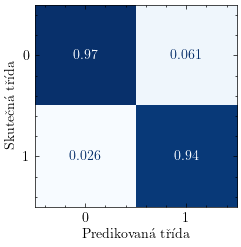

In [6]:
eval_model.load_weights(f"../results/models/WESAD_5s50.h5")

# Predict the values from the validation dataset
Y_pred = eval_model.predict(X_test)

utils.print_stats(y_test, Y_pred)
utils.plot_confusion_matrix(y_test, Y_pred, normalize="pred")
plt.savefig(f"{fpath}/wesad_5s50.pdf", format="pdf", bbox_inches="tight")

In [4]:
sm = SMOTETomek(random_state=42)
X_res, y_res = sm.fit_resample(X.reshape(len(X), -1), y)
X_res = X_res.reshape(-1, 32, 32, 3)

print(X_res.shape, y_res.shape)
print("Label counts: \n", pd.value_counts(y_res))

X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X_res, y_res, test_size=0.20, random_state=42)
print(X_train_res.shape, X_test_res.shape, y_train_res.shape, y_test_res.shape)

y_train_res = to_categorical(y_train_res, num_classes=2)
y_test_res = to_categorical(y_test_res, num_classes=2)

(14052, 32, 32, 3) (14052,)
Label counts: 
 0    7026
1    7026
dtype: int64
(11241, 32, 32, 3) (2811, 32, 32, 3) (11241,) (2811,)


In [8]:
model_name = "WESAD_5s50_AUG"
lr = 5e-4
epochs = 100
batch_size = 256

# Train model
train_model_aug, eval_model_aug = efinet.build_graph([32, 32, 3], 2)
trained_model_aug = efinet.train(model=train_model_aug, data=((X_train_res, y_train_res), (X_test_res, y_test_res)),
                                 epochs=epochs, lr=lr, model_name=model_name, batch_size=batch_size)







Epoch 1/100
37/37 [==============================] - ETA: 0s - loss: 0.3438 - Efficient_CapsNet_loss: 0.1669 - Generator_loss: 0.4513 - Efficient_CapsNet_accuracy: 0.8153
Epoch 1: val_Efficient_CapsNet_accuracy improved from -inf to 0.50496, saving model to ../results\models
37/37 [==============================] - 2s 33ms/step - loss: 0.3438 - Efficient_CapsNet_loss: 0.1669 - Generator_loss: 0.4513 - Efficient_CapsNet_accuracy: 0.8153 - val_loss: 0.5939 - val_Efficient_CapsNet_loss: 0.4390 - val_Generator_loss: 0.3951 - val_Efficient_CapsNet_accuracy: 0.5050 - lr: 5.0000e-04
Epoch 2/100
37/37 [==============================] - ETA: 0s - loss: 0.2143 - Efficient_CapsNet_loss: 0.0625 - Generator_loss: 0.3870 - Efficient_CapsNet_accuracy: 0.9090
Epoch 2: val_Efficient_CapsNet_accuracy improved from 0.50496 to 0.65287, saving model to ../results\models
37/37 [==============================] - 1s 21ms/step - loss: 0.2143 - Efficient_CapsNet_loss: 0.0625 - Generator_loss: 0.3870 - Eff

In [9]:
print("Train acc: ", np.round(np.max(trained_model_aug.history.history["Efficient_CapsNet_accuracy"]), 4))
print("Val acc: ", np.round(np.max(trained_model_aug.history.history["val_Efficient_CapsNet_accuracy"]), 4))

Train acc:  0.9997
Val acc:  0.9825


Accuracy = 0.9805950840879689
F1 Score = 0.9805946474661749
TPR = 0.9805973118919401
TNR =  0.9806445025991068
AUC = 0.9961571306575576


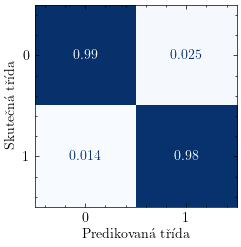

In [10]:
eval_model_aug.load_weights(f"../results/models/WESAD_5s50_AUG.h5")

# Predict the values from the validation dataset
Y_pred_aug = eval_model_aug.predict(X_test_res)

utils.print_stats(y_test_res, Y_pred_aug)
utils.plot_confusion_matrix(y_test_res, Y_pred_aug)
plt.savefig(f"{fpath}/wesad_5s50_aug.pdf", format="pdf", bbox_inches="tight")